In [2]:
# Imports: 

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from architectures_28x28.CKAN_BN import CKAN_BN
from architectures_28x28.SimpleModels import *
from architectures_28x28.ConvNet import ConvNet
from architectures_28x28.KANConvs_MLP import KANC_MLP
from architectures_28x28.KKAN import KKAN_Convolutional_Network
from architectures_28x28.conv_and_kan import NormalConvsKAN

In [3]:
# Dataset: 

# Transformation 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST and filtering for two classes 
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)

mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

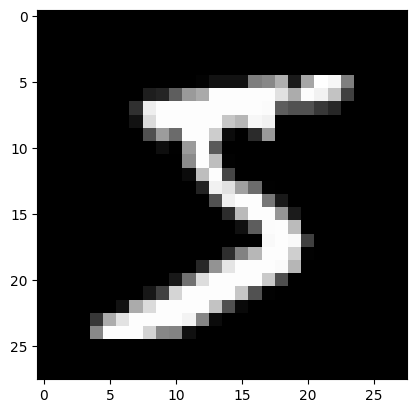

In [4]:
# print an image from the dataset 
plt.imshow(mnist_train[0][0].squeeze(), cmap='gray')

## Train and Test 

In [5]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    Train the model for one epoch

    Args:
        model: the neural network model
        device: cuda or cpu
        train_loader: DataLoader for training data
        optimizer: the optimizer to use (e.g. SGD)
        epoch: the current epoch
        criterion: the loss function (e.g. CrossEntropy)

    Returns:
        avg_loss: the average loss over the training set
    """

    model.to(device)
    model.train()
    train_loss = 0
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    # print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader, criterion):
    """
    Test the model

    Args:
        model: the neural network model
        device: cuda or cpu
        test_loader: DataLoader for test data
        criterion: the loss function (e.g. CrossEntropy)

    Returns:
        test_loss: the average loss over the test set
        accuracy: the accuracy of the model on the test set
        precision: the precision of the model on the test set
        recall: the recall of the model on the test set
        f1: the f1 score of the model on the test set
    """

    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += (target == predicted).sum().item()

            # Collect all targets and predictions for metric calculations
            all_targets.extend(target.view_as(predicted).cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Normalize test loss
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}\n'.format(
    #     test_loss, correct, len(test_loader.dataset), accuracy, precision, recall, f1))

    return test_loss, accuracy, precision, recall, f1

In [6]:
def train_and_test_models(model, device, train_loader, test_loader, optimizer, criterion, epochs, scheduler):
    """
    Train and test the model

    Args:
        model: the neural network model
        device: cuda or cpu
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        optimizer: the optimizer to use (e.g. SGD)
        criterion: the loss function (e.g. CrossEntropy)
        epochs: the number of epochs to train
        scheduler: the learning rate scheduler

    Returns:
        all_train_loss: a list of the average training loss for each epoch
        all_test_loss: a list of the average test loss for each epoch
        all_test_accuracy: a list of the accuracy for each epoch
        all_test_precision: a list of the precision for each epoch
        all_test_recall: a list of the recall for each epoch
        all_test_f1: a list of the f1 score for each epoch
    """
    # Track metrics
    all_train_loss = []
    all_test_loss = []
    all_test_accuracy = []
    all_test_precision = []
    all_test_recall = []
    all_test_f1 = []
    
    for epoch in range(1, epochs + 1):
        # Train the model
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        all_train_loss.append(train_loss)
        
        # Test the model
        test_loss, test_accuracy, test_precision, test_recall, test_f1 = test(model, device, test_loader, criterion)
        all_test_loss.append(test_loss)
        all_test_accuracy.append(test_accuracy)
        all_test_precision.append(test_precision)
        all_test_recall.append(test_recall)
        all_test_f1.append(test_f1)

        print(f'End of Epoch {epoch}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}')
        scheduler.step()
    model.all_test_accuracy = all_test_accuracy
    model.all_test_precision = all_test_precision
    model.all_test_f1 = all_test_f1
    model.all_test_recall = all_test_recall

    return all_train_loss, all_test_loss, all_test_accuracy, all_test_precision, all_test_recall, all_test_f1

## Set Device

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Models comparison: 

- Simple CNN 

In [36]:
model_SimpleCNN = FairNet()
model_SimpleCNN.to(device)
optimizer_SimpleCNN = optim.AdamW(model_SimpleCNN.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleCNN = optim.lr_scheduler.ExponentialLR(optimizer_SimpleCNN, gamma=0.8)
criterion_SimpleCNN = nn.CrossEntropyLoss()
all_train_loss_SimpleCNN, all_test_loss_SimpleCNN, all_test_accuracy_SimpleCNN, all_test_precision_SimpleCNN, all_test_recall_SimpleCNN, all_test_f1_SimpleCNN = train_and_test_models(model_SimpleCNN, device, train_loader, test_loader, optimizer_SimpleCNN, criterion_SimpleCNN, epochs=10, scheduler=scheduler_SimpleCNN)

100%|██████████| 938/938 [00:44<00:00, 21.15it/s]


End of Epoch 1: Train Loss: 0.143632, Test Loss: 0.0008, Accuracy: 98.44%


100%|██████████| 938/938 [00:43<00:00, 21.38it/s]


End of Epoch 2: Train Loss: 0.044688, Test Loss: 0.0006, Accuracy: 98.86%


100%|██████████| 938/938 [00:43<00:00, 21.36it/s]


End of Epoch 3: Train Loss: 0.029633, Test Loss: 0.0005, Accuracy: 99.08%


100%|██████████| 938/938 [00:42<00:00, 22.23it/s]


End of Epoch 4: Train Loss: 0.021485, Test Loss: 0.0005, Accuracy: 98.99%


100%|██████████| 938/938 [00:44<00:00, 21.29it/s]


End of Epoch 5: Train Loss: 0.015013, Test Loss: 0.0004, Accuracy: 99.07%


100%|██████████| 938/938 [00:44<00:00, 20.87it/s]


End of Epoch 6: Train Loss: 0.011461, Test Loss: 0.0004, Accuracy: 99.11%


100%|██████████| 938/938 [00:43<00:00, 21.70it/s]


End of Epoch 7: Train Loss: 0.008708, Test Loss: 0.0005, Accuracy: 99.16%


100%|██████████| 938/938 [00:43<00:00, 21.53it/s]


End of Epoch 8: Train Loss: 0.006062, Test Loss: 0.0004, Accuracy: 99.16%


100%|██████████| 938/938 [00:44<00:00, 20.88it/s]


End of Epoch 9: Train Loss: 0.004598, Test Loss: 0.0005, Accuracy: 99.02%


100%|██████████| 938/938 [00:41<00:00, 22.85it/s]


End of Epoch 10: Train Loss: 0.003669, Test Loss: 0.0004, Accuracy: 99.10%


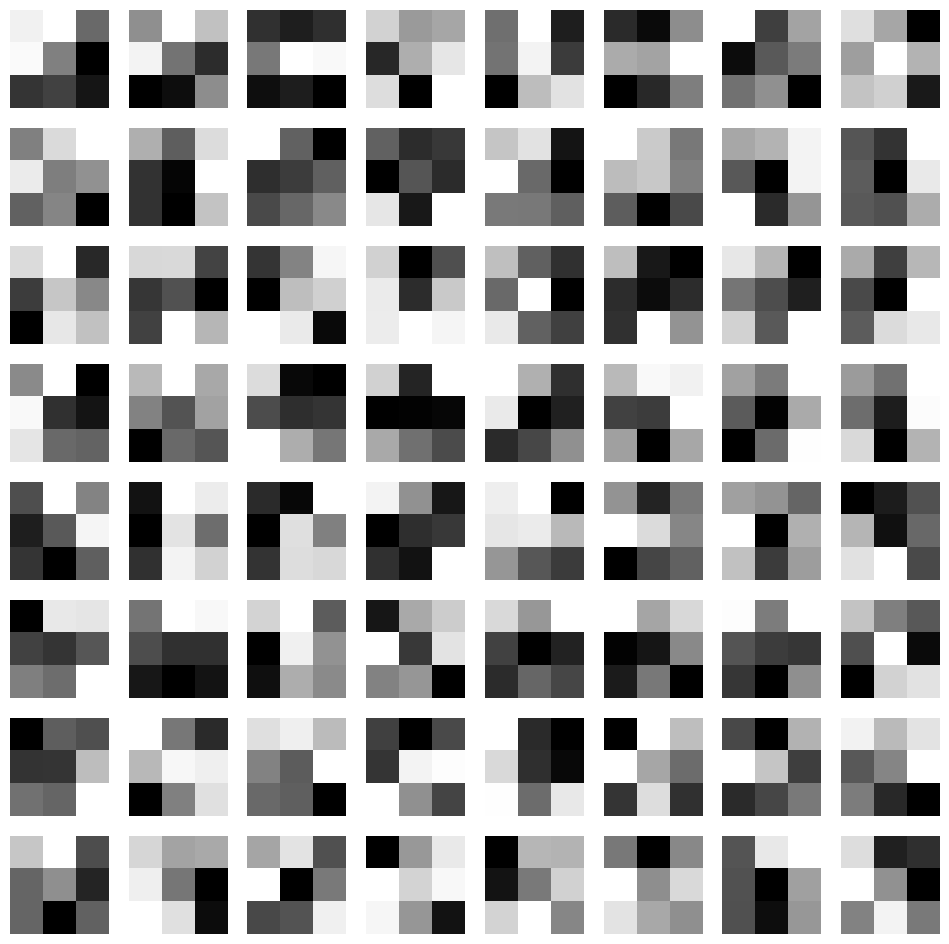

In [9]:
# Print the filters of the first layer 

model = model_SimpleCNN

# Weights of the first level 
filters = model.conv1.weight.data

# Number of filters to visualize 
n_filters = filters.shape[0]

# Plotting
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.flatten()


for i in range(n_filters):
    ax = axes[i]
    ax.imshow(filters[i, 0, :, :].cpu(), cmap='grey')
    ax.axis('off')

plt.show()

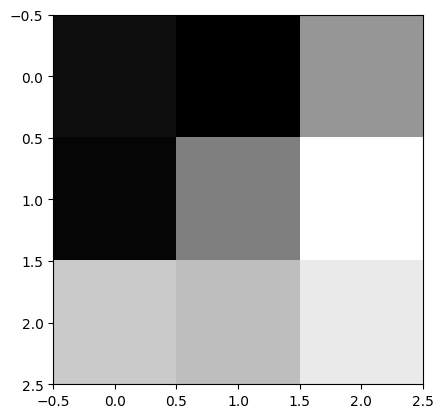

In [10]:
plt.imshow((1 - filters[0, 0, :, :].cpu()), cmap='gray')

- Second CNN (bigger) 

In [11]:
model_SimpleCNN_2 = SimpleCNN_2()
model_SimpleCNN_2.to(device)
optimizer_SimpleCNN_2 = optim.AdamW(model_SimpleCNN_2.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleCNN_2 = optim.lr_scheduler.ExponentialLR(optimizer_SimpleCNN_2, gamma=0.8)
criterion_SimpleCNN_2 = nn.CrossEntropyLoss()
all_train_loss_SimpleCNN_2, all_test_loss_SimpleCNN_2, all_test_accuracy_SimpleCNN_2, all_test_precision_SimpleCNN_2, all_test_recall_SimpleCNN_2, all_test_f1_SimpleCNN_2 = train_and_test_models(model_SimpleCNN_2, device, train_loader, test_loader, optimizer_SimpleCNN_2, criterion_SimpleCNN_2, epochs=10, scheduler=scheduler_SimpleCNN_2)

100%|██████████| 938/938 [00:10<00:00, 88.96it/s]


End of Epoch 1: Train Loss: 0.217629, Test Loss: 0.0010, Accuracy: 97.99%


100%|██████████| 938/938 [00:09<00:00, 95.08it/s]


End of Epoch 2: Train Loss: 0.060841, Test Loss: 0.0008, Accuracy: 98.32%


100%|██████████| 938/938 [00:09<00:00, 96.20it/s]


End of Epoch 3: Train Loss: 0.041468, Test Loss: 0.0006, Accuracy: 98.66%


100%|██████████| 938/938 [00:09<00:00, 94.98it/s]


End of Epoch 4: Train Loss: 0.030674, Test Loss: 0.0005, Accuracy: 98.91%


100%|██████████| 938/938 [00:10<00:00, 92.30it/s]


End of Epoch 5: Train Loss: 0.023745, Test Loss: 0.0005, Accuracy: 98.92%


100%|██████████| 938/938 [00:10<00:00, 87.11it/s]


End of Epoch 6: Train Loss: 0.018527, Test Loss: 0.0005, Accuracy: 99.00%


100%|██████████| 938/938 [00:09<00:00, 97.25it/s] 


End of Epoch 7: Train Loss: 0.014573, Test Loss: 0.0004, Accuracy: 99.11%


100%|██████████| 938/938 [00:10<00:00, 93.71it/s]


End of Epoch 8: Train Loss: 0.011873, Test Loss: 0.0005, Accuracy: 99.03%


100%|██████████| 938/938 [00:10<00:00, 93.54it/s] 


End of Epoch 9: Train Loss: 0.009505, Test Loss: 0.0004, Accuracy: 99.10%


100%|██████████| 938/938 [00:09<00:00, 94.63it/s] 


End of Epoch 10: Train Loss: 0.007884, Test Loss: 0.0004, Accuracy: 99.12%


- Convolutional KAN

In [30]:
model_KKAN_Convolutional_Network = KKAN_Convolutional_Network(device = device)
model_KKAN_Convolutional_Network.to(device)
optimizer_KKAN_Convolutional_Network = optim.AdamW(model_KKAN_Convolutional_Network.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_KKAN_Convolutional_Network = optim.lr_scheduler.ExponentialLR(optimizer_KKAN_Convolutional_Network, gamma=0.8)
criterion_KKAN_Convolutional_Network = nn.CrossEntropyLoss()

all_train_loss_KKAN_Convolutional_Network, all_test_loss_KKAN_Convolutional_Network, all_test_accuracy_KKAN_Convolutional_Network, all_test_precision_KKAN_Convolutional_Network, all_test_recall_KKAN_Convolutional_Network, all_test_f1_KKAN_Convolutional_Network = train_and_test_models(model_KKAN_Convolutional_Network, device, train_loader, test_loader, optimizer_KKAN_Convolutional_Network, criterion_KKAN_Convolutional_Network, epochs=10, scheduler=scheduler_KKAN_Convolutional_Network)

100%|██████████| 938/938 [10:07<00:00,  1.54it/s]


End of Epoch 1: Train Loss: 0.325821, Test Loss: 0.0014, Accuracy: 97.42%


100%|██████████| 938/938 [10:03<00:00,  1.55it/s]


End of Epoch 2: Train Loss: 0.073356, Test Loss: 0.0010, Accuracy: 98.22%


100%|██████████| 938/938 [10:07<00:00,  1.54it/s]


End of Epoch 3: Train Loss: 0.050306, Test Loss: 0.0008, Accuracy: 98.45%


100%|██████████| 938/938 [09:36<00:00,  1.63it/s]


End of Epoch 4: Train Loss: 0.038145, Test Loss: 0.0007, Accuracy: 98.56%


100%|██████████| 938/938 [09:18<00:00,  1.68it/s]


End of Epoch 5: Train Loss: 0.030583, Test Loss: 0.0007, Accuracy: 98.64%


100%|██████████| 938/938 [09:23<00:00,  1.67it/s]


End of Epoch 6: Train Loss: 0.025345, Test Loss: 0.0006, Accuracy: 98.75%


100%|██████████| 938/938 [21:05<00:00,  1.35s/it]   


End of Epoch 7: Train Loss: 0.021533, Test Loss: 0.0006, Accuracy: 98.79%


100%|██████████| 938/938 [09:58<00:00,  1.57it/s]


End of Epoch 8: Train Loss: 0.018853, Test Loss: 0.0006, Accuracy: 98.81%


100%|██████████| 938/938 [08:57<00:00,  1.75it/s]


End of Epoch 9: Train Loss: 0.016693, Test Loss: 0.0006, Accuracy: 98.77%


100%|██████████| 938/938 [09:05<00:00,  1.72it/s]


End of Epoch 10: Train Loss: 0.015149, Test Loss: 0.0006, Accuracy: 98.80%


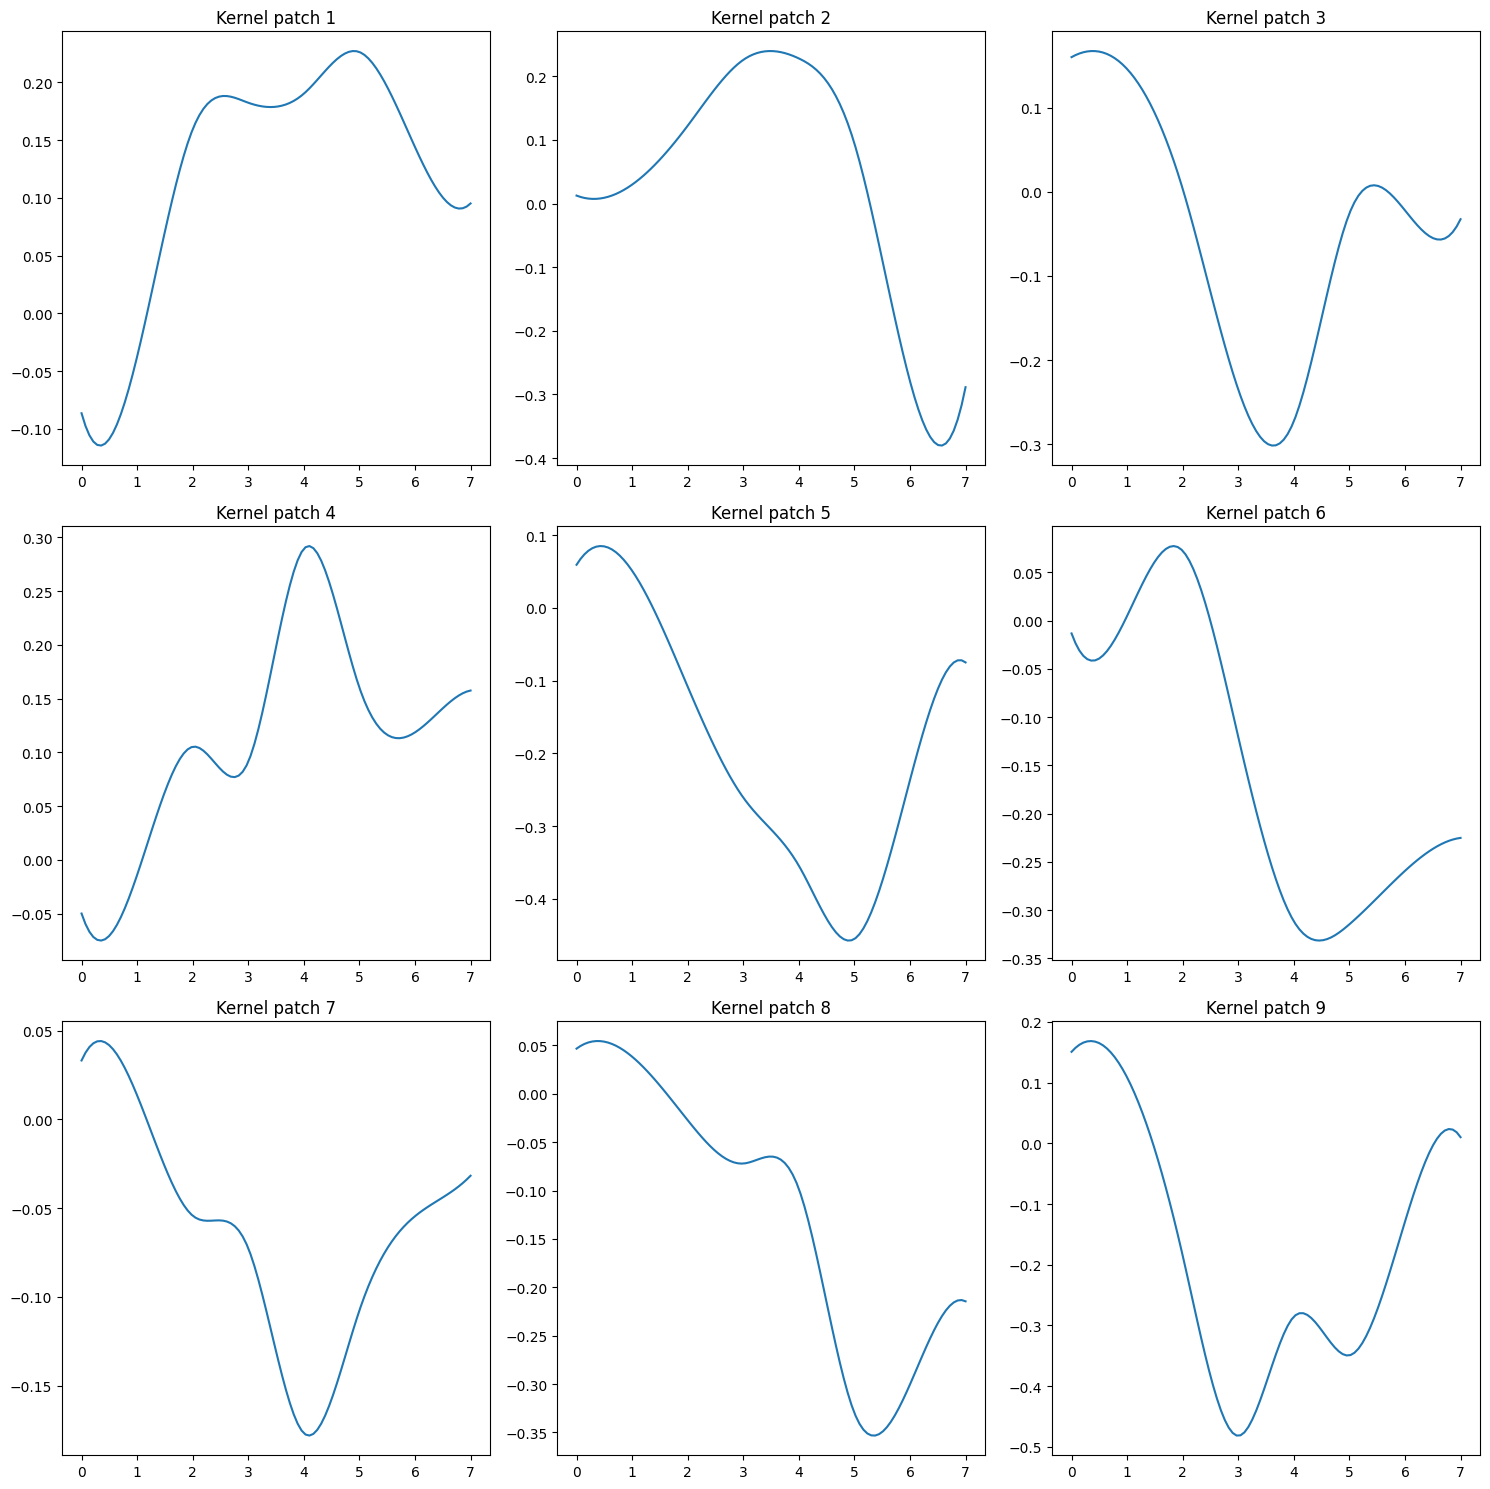

In [31]:
# Print the filters of the first Kan Convolution layer 
from scipy.interpolate import make_interp_spline

# Assuming model_KKAN_Convolutional_Network is defined and loaded appropriately

def smooth_data(x, y, num_points=100):
    """
    Smooth the data using spline interpolation.
    
    Args:
        x (list or np.array): The x-values of the data points.
        y (list or np.array): The y-values of the data points.
        num_points (int): Number of points for the interpolated curve.
    
    Returns:
        tuple: Smoothed x and y data points.
    """
    x_new = np.linspace(min(x), max(x), num_points)
    spl = make_interp_spline(x, y, k=3)  # Cubic spline interpolation
    y_smooth = spl(x_new)
    return x_new, y_smooth

def plot_spline_weights(model, layer_name, num_subplots=9, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i in range(num_subplots):
        # Get the spline weights for the i-th convolutional layer
        a = getattr(model, layer_name).convs[4].conv.spline_weight.squeeze()[i].detach().cpu().numpy()
        
        # Smooth the data
        x = list(range(len(a)))
        x_smooth, a_smooth = smooth_data(x, a)
        
        # Plot the smoothed weights
        axes[i].plot(x_smooth, a_smooth)
        axes[i].set_title(f"Kernel patch {i+1}")
        
    plt.tight_layout()
    plt.show()

plot_spline_weights(model_KKAN_Convolutional_Network, "conv1")

- Comparion between the two Networks 

In [32]:
acc_fairnet = all_test_accuracy_SimpleCNN 
acc_Simple2 = all_test_accuracy_SimpleCNN_2
acc_KAN = all_test_accuracy_KKAN_Convolutional_Network

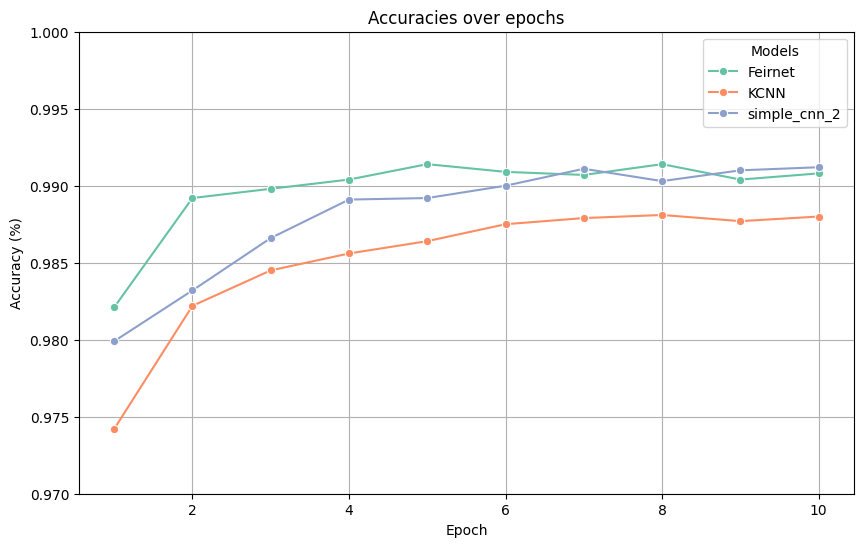

In [37]:
import seaborn as sns
data = {
    'Epoch': list(range(1, 11)),
    'fairnet': acc_fairnet,
    'KCNN': acc_KAN,
    'simple_CNN_2': acc_Simple2
}

df = pd.DataFrame(data)

# Set the seaborn style and palette
palette = sns.color_palette("Set2")

# Plotting the accuracies
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='fairnet', data=df, marker='o', label='Feirnet', color=palette[0])
sns.lineplot(x='Epoch', y='KCNN', data=df, marker='o', label='KCNN', color=palette[1])
sns.lineplot(x='Epoch', y='simple_CNN_2', data=df, marker='o', label='simple_cnn_2', color=palette[2])

# Adding titles and labels
plt.title('Accuracies over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(title='Models')
plt.ylim([0.97,1])
plt.grid()
# Show the plot
plt.show()